Cython's [typed memoryviews](http://docs.cython.org/src/userguide/memoryviews.html) provide a great interface for rectangular arrays. But I often need to represent jagged arrays such as the neighbours of nodes in a network. The standard python `dict` can represent such data nicely but is not statically typed. It can thus be quite slow compared with the templated containers in the C++ standard library. In this post, we'll have a look at how to use the power of the STL via cython.

Let's generate a directed [Erdos-Renyi network](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model) and represent it as an adjacency list.

In [1]:
%matplotlib inline
%load_ext cython
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (9, 6)

# Define the number of nodes and edge density
n = 1000
p = 0.01

# Generate a condensed adjacency matrix
adjacency = np.random.uniform(0, 1, (n, n)) < p
# Convert to an adjacency list
adjacency_list = np.transpose(np.nonzero(adjacency)).astype(np.int32)

## Representing the network as a mapping of neighbours

The adjacency list is not particularly useful if we want to look up the neighbours of a particular node because we have to iterate over the whole list. Let's convert the adjacency list to a dictionary that maps nodes to their neighbours.

In [2]:
adjacency_map = {}
# Iterate over all pairs of connected nodes
for u, v in adjacency_list:
    # Check if the node already has some neighbours
    neighbours = adjacency_map.get(u)
    if not neighbours:
        neighbours = adjacency_map[u] = []
    # Add to the list of neighbours
    neighbours.append(v)

It is now straightforward to look up the neighbours of different nodes. For example, the neighbours of node 42 are:

In [3]:
adjacency_map[42]

[127, 315, 550, 618, 738, 926]

## Using cython

Sometimes the standard python code just doesn't perform well enough, and we want to make use of statically typed C++ code. The [`map`](http://www.cplusplus.com/reference/map/map/) container is the analogue of a dictionary in python. As usual, C++ is a bit more cumbersome. Here we go.

In [22]:
%%cython

# distutils: language = c++
# cython: boundscheck = False

# Import the map and vector templates from the STL
from libcpp.map cimport map as cpp_map
from libcpp.vector cimport vector as cpp_vector
from libcpp.utility cimport pair as cpp_pair

ctypedef cpp_vector[int] cpp_neighbourhood
ctypedef cpp_map[int, cpp_neighbourhood] cpp_adjacency_map
ctypedef cpp_pair[int, cpp_neighbourhood] cpp_item

# Import a few operators because they aren't supported by cython syntax
from cython.operator cimport dereference as deref, preincrement as preinc

cdef class AdjacencyMap:
    cdef:
        cpp_adjacency_map container
        
    def __init__(self, int[:, :] adjacency_list):
        cdef:
            int i, ego, alter
            cpp_neighbourhood neighbourhood
            
        # Iterate over all entries of the adjacency list
        for i in range(adjacency_list.shape[0]):
            ego = adjacency_list[i, 0]
            alter = adjacency_list[i, 1]
            
            # Check if the ego is already in the map 
            # (see http://stackoverflow.com/a/101980/1150961 for details)
            lb = self.container.lower_bound(ego)
            
            # Check if the key already exists
            if lb != self.container.end() and ego == deref(lb).first:
                # Add the node to the pair
                deref(lb).second.push_back(alter)
            else:
                # Insert a new key value pair
                neighbourhood = cpp_neighbourhood()
                neighbourhood.push_back(alter)
                self.container.insert(lb, cpp_item(ego, neighbourhood))
                
    def get(self, int ego):
        """
        Get the neighbours of `ego` or `None` if `ego` isn't in the map.
        """
        # Search the dictionary
        iterator = self.container.find(ego)
        # Return none if we didn't find anything
        if iterator == self.container.end():
            return None
        # Create a list of values from the vector
        values = []
        # Iterate over the neighbourhood and add values to the list
        neighbourhood = deref(iterator).second
        neighbourhood_iterator = neighbourhood.begin()
        while neighbourhood_iterator != neighbourhood.end():
            values.append(deref(neighbourhood_iterator))
            preinc(neighbourhood_iterator)
            
        return values
    
    def _get_many(self, int[:] egos):
        """
        Simple function to illustrate overhead.
        """
        cdef int i
        # Try to find the ego a large number of times
        for i in range(egos.shape[0]):
            iterator = self.container.find(egos[i])

In [23]:
stl_adjacency_map = AdjacencyMap(adjacency_list)
stl_adjacency_map.get(42)

[127, 315, 550, 618, 738, 926]

## Comparison of the two implementations

Let's compare the two implementations in terms of performance.

In [21]:
%timeit adjacency_map.get(42)
%timeit stl_adjacency_map.get(42)

The slowest run took 31.22 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.63 µs per loop
The slowest run took 5.81 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 656 ns per loop


Ok, the complex implementation is a bit faster than the standard python implementation but it really doesn't seem worth the effort. It turns out the largest performance cost is the overhead from calling the C++ function from python. If we just want to look up neighbours in the C++ code, it's super fast. The class above has a simple function `_get_many` to illustrate this effect: it looks up the neighbours of a particular node a large number of times such that we can tease out how much the performance depends on the overhead.

In [25]:
# The number of repetitions to perform
repeats = [1, 10, 100, 1000, 10000]
cpp_times = []
# Use the timeit module to figure out how long it takes to call the function
for repeat in repeats:
    egos = np.random.randint(n, size=repeat).astype(np.int32)
    result = %timeit -o -q -r 20 stl_adjacency_map._get_many(egos)
    cpp_times.append(result)

In [26]:
# Do the same for python
def _get_many(egos):
    for ego in egos:
        adjacency_map.get(ego)

python_times = []
# Use the timeit module to figure out how long it takes to call the function
for repeat in repeats:
    egos = np.random.randint(n, size=repeat)
    result = %timeit -o -q -r 20 _get_many(egos)
    python_times.append(result)

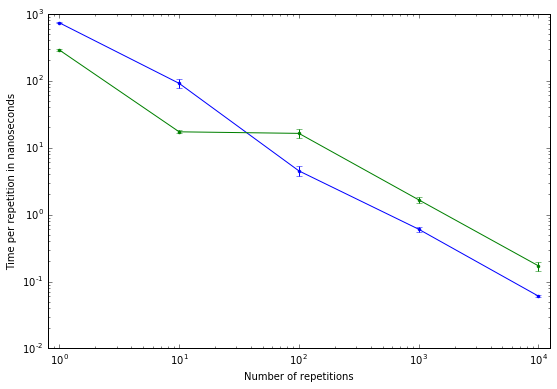

In [27]:
# Extract times and convert to nanoseconds
cpp = np.asarray([time.all_runs for time in cpp_times]) * 1e3
# Compute mean and standard deviation
cpp_mean = np.mean(cpp, axis=1) / repeats
cpp_std = np.std(cpp, axis=1) / repeats

# Extract times and convert to nanoseconds
python = np.asarray([time.all_runs for time in python_times]) * 1e3
# Compute mean and standard deviation
python_mean = np.mean(python, axis=1) / repeats
python_std = np.std(python, axis=1) / repeats

# Show two standard deviations
plt.errorbar(repeats, cpp_mean, 2 * cpp_std, marker='.', label='C++')
plt.errorbar(repeats, python_mean, 2 * python_std, marker='.', label='python')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of repetitions')
plt.ylabel('Time per repetition in nanoseconds')
# Fix the limits of the plot
f = 0.8
plt.xlim(1 * f, 1e4 / f)
pass

Wow, most of the computational time is taken up by the overhead of calling the function and converting the results into a format that python can handle (rather than a C++ vector).

In short, if you only want to look stuff up in a dictionary, don't bother implementing a wrapper for the STL. However, if you intend to do a lot of processing in cython, you can get enormous performance gains by putting in the effort to use statically typed containers.